# Nanorods Generator

## Load packages

In [1]:
import numpy as np
import math
import sys
import pickle
import time
import glob

In [22]:
import pylab as plt
%matplotlib inline 
from mpl_toolkits.mplot3d import Axes3D

In [3]:
class Stopwatch:
    start_time=None
    def go(self,msg=''):
        if msg:
            print(msg)
        self.start_time=time.time()
        sys.stdout.flush()
    def stop(self,msg=''):
        if msg:
            print("{}: {} seconds".format(msg,time.time()-self.start_time))
        else:
            print("Elapsed time: {} seconds".format(time.time()-self.start_time))
        sys.stdout.flush()
    def check(self):
        return time.time()-self.start_time

tic=Stopwatch()

## Distance between two segments

See paper "Robust Computation of Distance Between Line Segments" for details

In [4]:
# Compute the closest points on the line segments P(s) = (1-s)*P0 + s*P1 and Q(t) = (1-t)*Q0 + t*Q1 
# for 0 <= s <= 1 and 0 <= t <= 1.  The algorithm isrobust even for nearly parallel segments.  Effectively, it uses a conjugate
# gradient search for the minimum of the squared distance function, which
# avoids the numerical problems introduced by divisions in the case the
# minimum is located at an interior point of the domain.  See the document
# http://www.geometrictools.com/Documentation/DistanceLine3Line3.pdf for details.

def GetClampedRoot(slope, h0, h1):
#     Theoretically, r is in (0,1).  However, when the slope is nearly zero,
#     then so are h0 and h1.  Significant numerical rounding problems can
#     occur when using floating-point arithmetic.  If the rounding causes r
#     to be outside the interval, clamp it.  It is possible that r is in
#     (0,1) and has rounding errors, but because h0 and h1 are both nearly
#     zero, the quadratic is nearly constant on (0,1).  Any choice of p
#     should not cause undesirable accuracy problems for the final distance
#     computation.
    
#     NOTE:  You can use bisection to recompute the root or even use
#     bisection to compute the root and skip the division.  This is generally
#     slower, which might be a problem for high-performance applications.

    if (h0 < 0):
        if (h1 > 0):
            r = -h0 / slope
            if (r > 1):
                r = 0.5
#             The slope is positive and -h0 is positive, so there is no
#             need to test for a negative value and clamp it.
        else:
            r = 1.0
    else:
        r = 0.0
    return r

In [5]:
def ComputeIntersection(sValue, classify, ABC):
#     The divisions are theoretically numbers in [0,1].  Numerical rounding
#     errors might cause the result to be outside the interval.  When this
#     happens, it must be that both numerator and denominator are nearly
#     zero.  The denominator is nearly zero when the segments are nearly
#     perpendicular.  The numerator is nearly zero when the P-segment is
#     nearly degenerate (mF00 = a is small).  The choice of 0.5 should not
#     cause significant accuracy problems.
    
#     NOTE:  You can use bisection to recompute the root or even use
#     bisection to compute the root and skip the division.  This is generally
#     slower, which might be a problem for high-performance applications.
    
    edge=[0,0]
    end=np.zeros([2,2])
    if (classify[0] < 0):
        edge[0] = 0
        end[0][0] = 0
        end[0][1] = ABC['mF00'] / ABC['mB']
        if (end[0][1] < 0 or end[0][1] > 1):
            end[0][1] = 0.5
        if (classify[1] == 0):
            edge[1] = 3
            end[1][0] = sValue[1]
            end[1][1] = 1
        else:  # classify[1] > 0
            edge[1] = 1;
            end[1][0] = 1;
            end[1][1] = ABC['mF10'] / ABC['mB'];
            if (end[1][1] < 0 or end[1][1] > 1):
                end[1][1] = 0.5
    elif (classify[0] == 0):
        edge[0] = 2
        end[0][0] = sValue[0]
        end[0][1] = 0
        if (classify[1] < 0):
            edge[1] = 0
            end[1][0] = 0
            end[1][1] = ABC['mF00'] / ABC['mB']
            if (end[1][1] < 0 or end[1][1] > 1):
                end[1][1] = 0.5
        elif (classify[1] == 0):
            edge[1] = 3;
            end[1][0] = sValue[1]
            end[1][1] = 1
        else:
            edge[1] = 1
            end[1][0] = 1
            end[1][1] = ABC['mF10'] / ABC['mB']
            if (end[1][1] < 0 or end[1][1] > 1):
                end[1][1] = 0.5
    else:  # classify[0] > 0
        edge[0] = 1
        end[0][0] = 1
        end[0][1] = ABC['mF10'] / ABC['mB']
        if (end[0][1] < 0 or end[0][1] > 1):
            end[0][1] = 0.5
        if (classify[1] == 0):
            edge[1] = 3;
            end[1][0] = sValue[1];
            end[1][1] = 1;
        else:
            edge[1] = 0;
            end[1][0] = 0;
            end[1][1] = ABC['mF00'] / ABC['mB'];
            if (end[1][1] < 0 or end[1][1] > 1):
                end[1][1] = 0.5
    return edge,end

In [6]:
def ComputeMinimumParameters(edge, end, ABC):
    delta = end[1][1] - end[0][1];
    h0 = delta * (-ABC['mB'] * end[0][0] + ABC['mC'] * end[0][1] - ABC['mE']);
    parameter = np.zeros(2)
    if (h0 >= 0):
        if (edge[0] == 0):
            parameter[0] = 0;
            parameter[1] = GetClampedRoot(ABC['mC'], ABC['mG00'], ABC['mG01']);
        elif (edge[0] == 1):
            parameter[0] = 1;
            parameter[1] = GetClampedRoot(ABC['mC'], ABC['mG10'], ABC['mG11']);
        else:
            parameter[0] = end[0][0];
            parameter[1] = end[0][1];
    else:
        h1 = delta * (-ABC['mB'] * end[1][0] + ABC['mC'] * end[1][1] - ABC['mE']);
        if (h1 <= 0):
            if (edge[1] == 0):
                parameter[0] = 0;
                parameter[1] = GetClampedRoot(ABC['mC'], ABC['mG00'], ABC['mG01']);
            elif (edge[1] == 1):
                parameter[0] = 1;
                parameter[1] = GetClampedRoot(ABC['mC'], ABC['mG10'], ABC['mG11']);
            else:
                parameter[0] = end[1][0];
                parameter[1] = end[1][1];
        else:  # h0 < 0 and h1 > 0
            z = min(max(h0 / (h0 - h1), 0), 1);
            omz = 1 - z;
            parameter[0] = omz * end[0][0] + z * end[1][0];
            parameter[1] = omz * end[0][1] + z * end[1][1];
    return parameter

In [7]:
def distance(P0,P1,Q0,Q1,return_points=False):
    st=np.zeros(2)
    points=[np.zeros(2)]*2
    
    P1mP0 = P1 - P0
    Q1mQ0 = Q1 - Q0
    P0mQ0 = P0 - Q0
    
    ABC=dict()
    ABC['mA'] = np.dot(P1mP0, P1mP0)
    ABC['mB'] = np.dot(P1mP0, Q1mQ0)
    ABC['mC'] = np.dot(Q1mQ0, Q1mQ0)
    ABC['mD'] = np.dot(P1mP0, P0mQ0)
    ABC['mE'] = np.dot(Q1mQ0, P0mQ0)

    ABC['mF00'] = ABC['mD']
    ABC['mF10'] = ABC['mF00'] + ABC['mA']
    ABC['mF01'] = ABC['mF00'] - ABC['mB']
    ABC['mF11'] = ABC['mF10'] - ABC['mB']

    ABC['mG00'] = -ABC['mE']
    ABC['mG10'] = ABC['mG00'] - ABC['mB']
    ABC['mG01'] = ABC['mG00'] + ABC['mC']
    ABC['mG11'] = ABC['mG10'] + ABC['mC']
    
    if (ABC['mA'] > 0 and ABC['mC'] > 0):
#         Compute the solutions to dR/ds(s0,0) = 0 and dR/ds(s1,1) = 0.  The
#         location of sI on the s-axis is stored in classifyI (I = 0 or 1).  If
#         sI <= 0, classifyI is -1.  If sI >= 1, classifyI is 1.  If 0 < sI < 1,
#         classifyI is 0.  This inforABC['mA']tion helps determine where to search for
#         the minimum point (s,t).  The fij values are dR/ds(i,j) for i and j in {0,1}.

        sValue=np.zeros(2)
        sValue[0] = GetClampedRoot(ABC['mA'], ABC['mF00'], ABC['mF10']);
        sValue[1] = GetClampedRoot(ABC['mA'], ABC['mF01'], ABC['mF11']);

        classify=[0,0]
        for i in range(2):
            if (sValue[i] <= 0):
                classify[i] = -1
            elif (sValue[i] >= 1):
                classify[i] = 1
            else:
                classify[i] = 0

        if (classify[0] == -1 and classify[1] == -1):
#             The minimum must occur on s = 0 for 0 <= t <= 1.
            st[0] = 0
            st[1] = GetClampedRoot(ABC['mC'], ABC['mG00'], ABC['mG01'])
        elif (classify[0] == 1 and classify[1] == 1):
#             The minimum must occur on s = 1 for 0 <= t <= 1.
            st[0] = 1
            st[1] = GetClampedRoot(ABC['mC'], ABC['mG10'], ABC['mG11'])
        else:
#             The line dR/ds = 0 intersects the doABC['mA']in [0,1]^2 in a
#             nondegenerate segABC['mE']nt.  Compute the endpoints of that segABC['mE']nt,
#             end[0] and end[1].  The edge[i] flag tells you on which doABC['mA']in
#             edge end[i] lives: 0 (s=0), 1 (s=1), 2 (t=0), 3 (t=1).
        
            edge,end=ComputeIntersection(sValue, classify, ABC);

#             The directional derivative of R along the segABC['mE']nt of intersection is
#             H(z) = (end[1][1]-end[1][0])*dR/dt((1-z)*end[0] + z*end[1])
#             for z in [0,1].  The formula uses the fact that dR/ds = 0 on
#             the segABC['mE']nt.  Compute the minimum of H on [0,1].
            
            st = ComputeMinimumParameters(edge, end, ABC);
    else:
        if (ABC['mA'] > 0):
            # The Q-segABC['mE']nt is degenerate (Q0 and Q1 are the saABC['mE'] point) and
            # the quadratic is R(s,0) = a*s^2 + 2*d*s + f and has (half)
            # first derivative F(t) = a*s + d.  The closest P-point is
            # interior to the P-segABC['mE']nt when F(0) < 0 and F(1) > 0.
            st[0] = GetClampedRoot(ABC['mA'], ABC['mF00'], ABC['mF10']);
            st[1] = 0;
        elif (ABC['mC'] > 0):
            # The P-segABC['mE']nt is degenerate (P0 and P1 are the saABC['mE'] point) and
            # the quadratic is R(0,t) = c*t^2 - 2*e*t + f and has (half)
            # first derivative G(t) = c*t - e.  The closest Q-point is
            # interior to the Q-segABC['mE']nt when G(0) < 0 and G(1) > 0.
            st[0] = 0;
            st[1] = GetClampedRoot(ABC['mC'], ABC['mG00'], ABC['mG01']);
        else:
            # P-segABC['mE']nt and Q-segABC['mE']nt are degenerate.
            st[0] = 0;
            st[1] = 0;

    points[0] = (1 - st[0]) * P0 + st[0] * P1;
    points[1] = (1 - st[1]) * Q0 + st[1] * Q1;
    diff = points[0] - points[1];
    sqrdistance = np.dot(diff, diff);
    if return_points:
        return np.sqrt(sqrdistance), points, st
    else:
        return np.sqrt(sqrdistance)

### Test

#### Test 1

In [32]:
P0=np.array((-1.0264718499965966,9.6163341007195407e-007,0.0))
P1=np.array((0.91950808032415809,-1.0094441192690283e-006,0.0))
Q0=np.array((-1.0629447383806110,9.2709540082141753e-007,0.0))
Q1=np.array((1.0811583868227901,-1.0670017179567367e-006,0.0))

In [33]:
distance(P0,P1,Q0,Q1)
# sT r ue = 0. 4 2 4 5 7 2 8 1 9 3 4 2 5 2 2 6 1
# tT r ue = 0. 4 0 2 3 5 1 4 8 3 7 7 1 2 9 6 7 6
# d i s t a n c e T r u e = 0

(9.730718934530454e-10,
 [array([-2.12005334e-01,  1.36662595e-07,  0.00000000e+00]),
  array([-2.12005334e-01,  1.35689523e-07,  0.00000000e+00])],
 array([0.41853798, 0.39687429]))

#### Test 2

In [36]:
P0=np.array((-1.0896217473782599,9.7236145595088601e-007,0.0))
P1=np.array((0.91220578597858548,-9.4369829432107506e-007,0.0))
Q0=np.array((-0.90010447502136237,9.0671446351334441e-007,0.0))
Q1=np.array((1.0730877178721130,-9.8185787633992740e-007,0.0))

In [37]:
distance(P0,P1,Q0,Q1)
# sT r ue = 0. 0 9 4 6 7 2 1 2 7 9 4 2 5 0 4 1 5 3
# tT r ue = 0
# d i s t a n c e T r u e = 1. 1 5 7 5 0 4 6 1 3 8 5 7 4 1 0 5 e−007

(1.1582296851547987e-07,
 [array([ 9.12205786e-01, -9.43698294e-07,  0.00000000e+00]),
  array([ 9.12205786e-01, -8.27875326e-07,  0.00000000e+00])],
 array([1.        , 0.91846616]))

#### Test 3

In [38]:
P0=np.array((0.77998990099877119,0.61192502360790968,-0.22703111823648214))
P1=np.array((0.53215344529598951,0.85724585503339767,-0.10102437809109688))
Q0=np.array((-0.21277333982288837,0.35091548087075353,-0.49557160679250956))
Q1=np.array((0.11881479667499661,0.022494725417345762,-0.66426620958372951))

In [39]:
distance(P0,P1,Q0,Q1)
# sT r ue = 1
# tT r ue = 0. 0 5 7 5 0 4 2 1 9 5 2 2 7 6 2 1 7 6
# d i s t a n c e T r u e = 0. 9 8 2 9 2 3 9 7 1 1 6 4 8 8 7 3 9

(0.9829239711648874,
 [array([ 0.53215345,  0.85724586, -0.10102438]),
  array([-0.19370562,  0.3320299 , -0.50527226])],
 array([1.        , 0.05750422]))

#### Test 4

In [40]:
delta=0.25 * 1e-04;
epsilon=np.sqrt(delta);
phi=1e-05;
P0=np.array((0,0,0))
P1=np.array((1,0,0))
Q0=np.array((-epsilon,phi+delta,0))
Q1=np.array((epsilon,phi-delta,0))

In [41]:
distance(P0,P1,Q0,Q1)
# sT r ue = 0. 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
# tT r ue = 0. 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7
# d i s t a n c e T r u e = 0. 0

(2.7122314947662727e-17,
 [array([0.002, 0.   , 0.   ]),
  array([ 2.00000000e-03, -2.71084424e-17,  0.00000000e+00])],
 array([0.002, 0.7  ]))

## Generate rods

In [16]:
def generate_rods(nrods,rodlen,boxleng,orient='random',filename=''):
    x=np.random.rand(nrods)*boxleng;
    y=np.random.rand(nrods)*boxleng;
    z=np.random.rand(nrods)*boxleng;
    if orient=='random':
        ex=np.random.randn(nrods);
        ey=np.random.randn(nrods);
        ez=np.random.randn(nrods);
        r=np.sqrt(ex*ex+ey*ey+ez*ez)
        ex=ex/r
        ey=ey/r
        ez=ez/r
    elif orient=='nematic':
        ex=np.random.randn(nrods)*0.01
        ey=np.random.randn(nrods)*0.01
        ez=np.ones(nrods)
    else:
        raise("No Such Orientation!")
    if filename:
        np.savetxt(filename,np.array((x-0.5*rodlen*ex,y-0.5*rodlen*ey,z-0.5*rodlen*ez,
                                      x+0.5*rodlen*ex,y+0.5*rodlen*ey,z+0.5*rodlen*ez)).T)
    return (x-0.5*rodlen*ex,y-0.5*rodlen*ey,z-0.5*rodlen*ez,x+0.5*rodlen*ex,y+0.5*rodlen*ey,z+0.5*rodlen*ez)


def get_network(X1,Y1,Z1,X2,Y2,Z2,filename=''):
    if filename:
        outfile=open(filename,'w')
    adj=dict()
    for i in range(len(X1)):
        adj[i]=list()
    for i in range(len(X1)):
        P1=np.array([X1[i],Y1[i],Z1[i]])
        P2=np.array([X2[i],Y2[i],Z2[i]])
        for j in range(i+1,len(X1)):
            Q1=np.array((X1[j],Y1[j],Z1[j]))
            Q2=np.array((X2[j],Y2[j],Z2[j]))
            dij=distance(P1,P2,Q1,Q2)
            if dij<=2*r:
                adj[i].append(j)
                adj[j].append(i)
                if filename:
                    outfile.write('{} {}\n'.format(i,j))
    if filename:
        outfile.close()
    return adj

In [17]:
nrealizations=50;
r=0.5;
rodlen=50;
boxlen=10*(rodlen+2*r);
nrods=10#int(sys.argv[1]);
cutoff=2*r;
degrees=[]

In [35]:
tic=Stopwatch()
tic.go()
X1,Y1,Z1,X2,Y2,Z2=generate_rods(nrods,rodlen,boxlen,orient='nematic')
adj=get_network(X1,Y1,Z1,X2,Y2,Z2)
tic.stop()

Elapsed time: 0.0045928955078125 seconds


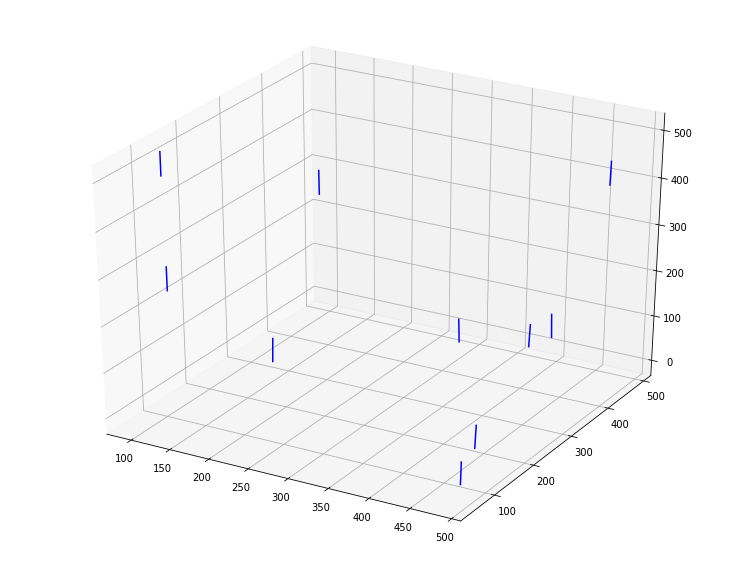

In [36]:
fig = plt.figure(figsize=[13,10])
ax = fig.add_subplot(111, projection='3d')
for i in range(len(X1)):
    ax.plot([X1[i],X2[i]],[Y1[i],Y2[i]],[Z1[i],Z2[i]],'b');